In [1]:
import os

import pandas as pd
import preprocess
import torch
import numpy as np
from datasets import load_dataset
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, f1_score
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from augmentations import balance_classes_with_augmentation

In [3]:
dataset1 = pd.DataFrame(load_dataset('financial_phrasebank', 'sentences_allagree')['train'])
dataset2 = pd.DataFrame(load_dataset('financial_phrasebank', 'sentences_75agree')['train'])
dataset3 = pd.DataFrame(load_dataset('financial_phrasebank', 'sentences_66agree')['train'])

In [ ]:
train = pd.concat([dataset1, dataset2, dataset3])
train.groupby('label').describe()

In [ ]:
train['sentence'] = train['sentence'].astype(str)
train['sentence'] = train['sentence'].apply(preprocess.preprocess_df)
train['sentence'] = train['sentence'].astype(str)
train = train[['sentence', 'label']]
train.to_csv('combinedData.csv')

In [6]:
train = pd.read_csv('combinedData.csv')
train['sentence'] = train['sentence'].astype(str)

In [9]:
train = train[['label', 'sentence']]
train.groupby('label').describe()

sentence                                                               
         count unique                                                top freq
label                                                                        
0         1237    504                operating profit fell eur mn eur mn    9
1         6072   2500                                 value order eur mn   21
2         2625   1142  operating profit rose eur mn eur mn correspond...   18

TRAINING


In [12]:
sentences = train['sentence'].values
labelss = train['label'].values
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(labelss)

train_sentences, eval_sentences, train_labels, eval_labels = train_test_split(
    sentences, labels, test_size=0.2, stratify=labels, random_state=42
)

tokenizer = RobertaTokenizer.from_pretrained('roberta-large')
model = RobertaForSequenceClassification.from_pretrained('roberta-large', num_labels=3)  

batch_size = 16
epochs = 3 
learning_rate = 2e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

optimizer = AdamW(model.parameters(), lr=learning_rate, betas=(0.9, 0.99), eps=1e-08)
loss_fn = torch.nn.CrossEntropyLoss()

eval_encodings = tokenizer(list(eval_sentences), truncation=True, padding=True, max_length=256, return_tensors='pt')
eval_dataset = TensorDataset(eval_encodings['input_ids'], eval_encodings['attention_mask'], torch.tensor(eval_labels))
eval_loader = DataLoader(eval_dataset, batch_size=batch_size)

k_folds = 5 
skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

train_losses = []
train_acc = []
val_losses = []
val_acc = []
eval_losses = []
eval_acc = []
f1_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(train_sentences, train_labels)):
    print(f"Fold {fold + 1}/{k_folds}")
    train_sentences_fold, val_sentences_fold = train_sentences[train_idx], train_sentences[val_idx]
    train_labels_fold, val_labels_fold = train_labels[train_idx], train_labels[val_idx]
    train_encodings = tokenizer(list(train_sentences_fold), truncation=True, padding=True, max_length=128, return_tensors='pt')
    val_encodings = tokenizer(list(val_sentences_fold), truncation=True, padding=True, max_length=128, return_tensors='pt')

    train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], torch.tensor(train_labels_fold))
    val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'], torch.tensor(val_labels_fold))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        correct_train = 0
        total_train = 0

        for batch in train_loader:
            input_ids, attention_mask, target = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=target)
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        _, predicted_train = torch.max(outputs.logits, 1)
        correct_train += (predicted_train == target).sum().item()
        total_train += target.size(0) 

        if total_train != 0:
            average_train_loss = total_loss / len(train_loader)
            train_losses.append(average_train_loss)
            train_accuracy = correct_train / total_train
            train_acc.append(train_accuracy)
            print(f"Fold {fold + 1}/{k_folds}, Epoch {epoch + 1}/{epochs} - Average training loss: {average_train_loss:.4f} - Training accuracy: {train_accuracy:.4f}")
        else:
            print(f"Fold {fold + 1}/{k_folds}, Epoch {epoch + 1}/{epochs} - No training samples.")

    model.eval()
    correct_val = 0
    total_val = 0
    val_loss = 0

    val_targets = []
    val_predictions = []

    with torch.no_grad():
        for batch in val_loader:
            input_ids, attention_mask, target = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=target)
            logits = outputs.logits
            loss = outputs.loss
            val_loss += loss.item()

            _, predicted_val = torch.max(logits, 1)
            correct_val += (predicted_val == target).sum().item()
            total_val += target.size(0)

            val_targets.extend(target.cpu().detach().numpy())
            val_predictions.extend(predicted_val.cpu().detach().numpy())

    average_val_loss = val_loss / len(val_loader)
    val_losses.append(average_val_loss)
    val_accuracy = correct_val / total_val
    val_acc.append(val_accuracy)
    print(f"Fold {fold + 1}/{k_folds} - Average validation loss: {average_val_loss:.4f} - Validation accuracy: {val_accuracy:.4f}")
    
    model.eval()
    correct_eval = 0
    total_eval = 0
    eval_loss = 0

    with torch.no_grad():
        for batch in eval_loader:
            input_ids, attention_mask, target = batch
            input_ids, attention_mask, target = input_ids.to(device), attention_mask.to(device), target.to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=target)
            logits = outputs.logits
            loss = outputs.loss
            eval_loss += loss.item()

            _, predicted_eval = torch.max(logits, 1)
            correct_eval += (predicted_eval == target).sum().item()
            total_eval += target.size(0)

    average_eval_loss = eval_loss / len(eval_loader)
    eval_losses.append(average_eval_loss)
    eval_accuracy = correct_eval / total_eval
    eval_acc.append(eval_accuracy)
    
    print(f"Fold {fold + 1}/{k_folds} - Separate Evaluation - Average loss: {average_eval_loss:.4f} - Accuracy: {eval_accuracy:.4f}")

    
    f1 = f1_score(val_targets, val_predictions, average='weighted')
    f1_scores.append(f1)
    
    class_names = [str(label) for label in label_encoder.classes_]
    report = classification_report(val_targets, val_predictions, target_names=class_names)
    print(f"Fold {fold + 1}/{k_folds} - F1 score: {f1:.4f}")


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/.virtualenvs/DM/lib/python3.10/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Fold 1/5
Fold 1/5, Epoch 1/3 - Average training loss: 0.4622 - Training accuracy: 1.0000
Fold 1/5, Epoch 2/3 - Average training loss: 0.2295 - Training accuracy: 1.0000
Fold 1/5, Epoch 3/3 - Average training loss: 0.1610 - Training accuracy: 1.0000
Fold 1/5 - Average validation loss: 0.3248 - Validation accuracy: 0.8981
Fold 1/5 - Separate Evaluation - Average loss: 0.2853 - Accuracy: 0.9104
Fold 1/5 - F1 score: 0.9000
Fold 2/5
Fold 2/5, Epoch 1/3 - Average training loss: 0.1446 - Training accuracy: 1.0000
Fold 2/5, Epoch 2/3 - Average training loss: 0.1079 - Training accuracy: 0.8000
Fold 2/5, Epoch 3/3 - Average training loss: 0.0847 - Training accuracy: 1.0000
Fold 2/5 - Average validation loss: 0.0902 - Validation accuracy: 0.9711
Fold 2/5 - Separate Evaluation - Average loss: 0.1785 - Accuracy: 0.9421
Fold 2/5 - F1 score: 0.9713
Fold 3/5
Fold 3/5, Epoch 1/3 - Average training loss: 0.0821 - Training accuracy: 1.0000
Fold 3/5, Epoch 2/3 - Average training loss: 0.0702 - Training ac

In [13]:
print(report)

              precision    recall  f1-score   support

           0       0.99      0.89      0.94       198
           1       1.00      0.99      1.00       971
           2       0.95      0.99      0.97       420

    accuracy                           0.98      1589
   macro avg       0.98      0.96      0.97      1589
weighted avg       0.98      0.98      0.98      1589


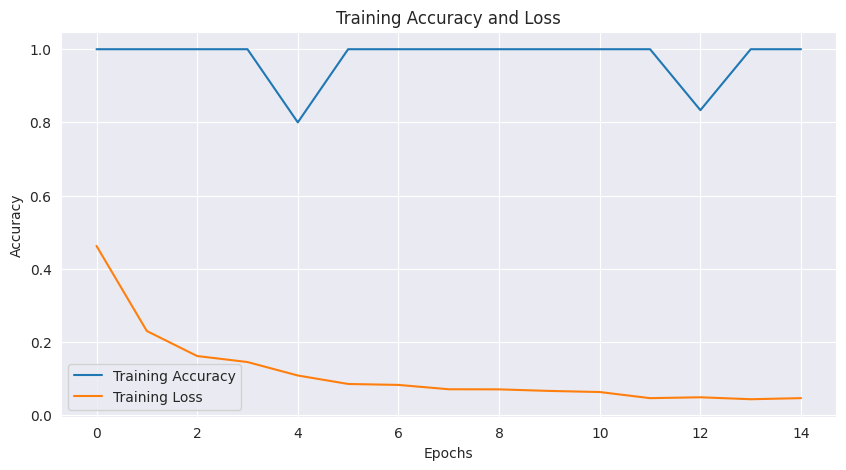

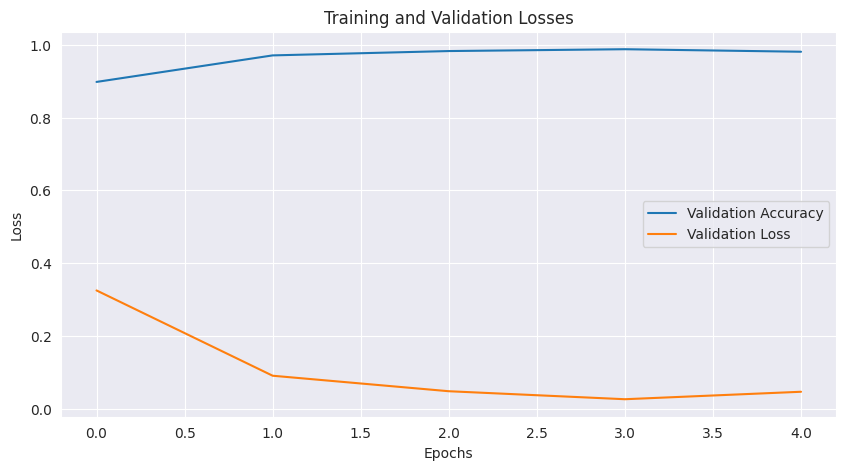

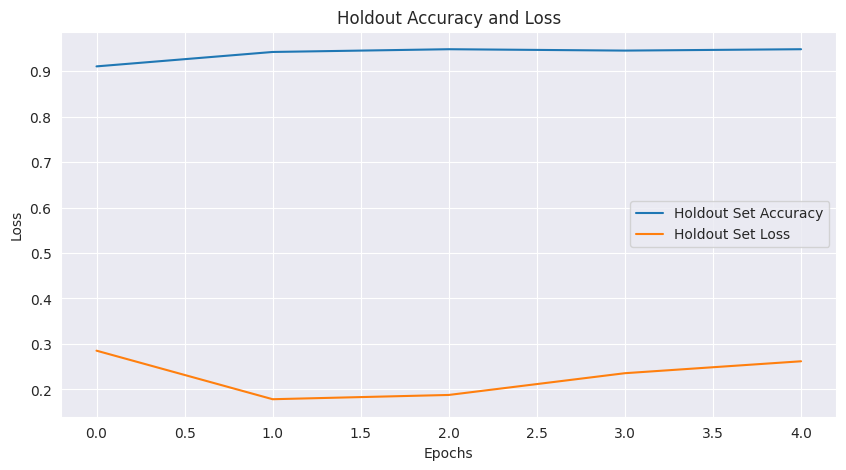

In [19]:
import matplotlib.pyplot as plt

# Plotting training accuracies and losses
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy and Loss')
plt.legend()
plt.show()

# Plotting validation acccuracies and losses
plt.figure(figsize=(10, 5))
plt.plot(val_acc, label='Validation Accuracy')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plotting the holdout set accuracies and losses
plt.figure(figsize=(10, 5))
plt.plot(eval_acc, label='Holdout Set Accuracy')
plt.plot(eval_losses, label='Holdout Set Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Holdout Accuracy and Loss')
plt.legend()
plt.show()


Saving the model

In [26]:
model.save_pretrained(os.getcwd())